# Evaluation of Perturbations/Randomizations of Data
I conducted experiments in which I perturbed the original data I was using. This notebook computes and plots PR curves from the different perturbations of:
* **the PPI network**. I randomly shuffled 50% or 100% of the edges, preserving the node degree. I also added two random networks, one that preserves the node degree and one that doesn't.
* **the multi-omics features**. I again shuffled 50% or 100% of the node features around. I also added random features (twice to match with the number of perturbations with networks).
* **both of them**. I also created containers where I perturbed both, features and the network.

I expect the performance to drop when the data becomes less informative and more random. At the same time, we know that the study bias of cancer genes is quite high so that I expect much more extreme drops in performance when the node degree is not preserved. The random network with maintained node degree should give us a nice baseline here.

In [1]:
import pandas as pd
import numpy as np
import networkx as nx
import os, sys

from sklearn.metrics import precision_recall_curve, average_precision_score
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.ensemble import RandomForestClassifier

sys.path.append(os.path.abspath('../EMOGI'))
import gcnIO
import postprocessing

sys.path.append(os.path.abspath('../pagerank'))
import pagerank

import matplotlib.pyplot as plt
import seaborn as sns

plt.rc('font', family='Helvetica')

%matplotlib inline

## Parameters

* `perturbation_to_analyse`: Which of the perturbations we are currently looking at. Can be any of:
    1. _network_ for analysis of network perturbations
    2. _features_ for analysis of feature perturbations
    3. _netfeat_ for analysis of both, network and feature perturbations at the same time

In [2]:
perturbation_to_analyse = 'features'

## Functions

In [3]:
perturbation_folder = '../data/GCN/training/2020_09_28_12_04_47/' # features CPDB new

In [4]:
def _get_printable_name(raw_name):
    if raw_name.startswith('0_25_'):
        return "25% Edited"
    elif raw_name.startswith('0_5_'):
        return "50% Edited"
    elif raw_name.startswith('0_75_'):
        return "75% Edited"
    elif raw_name.startswith('0_'):
        return "Original"
    elif raw_name.startswith('1_'):
        return "100% Edited"
    elif raw_name.startswith('Random_degreepreserved'):
        return "Random\n(exp. Degree)"
    elif raw_name.startswith('Random_powerlaw'):
        return "Random\n(Power Law)"
    else:
        return raw_name

def _performance(y_true, y_score, metric='aupr'):
    if metric.upper() == 'AUPR':
        pr, rec, thresholds = precision_recall_curve(y_true=y_true, probas_pred=y_score)
        aupr = average_precision_score(y_true=y_true, y_score=y_score)
        return pr, rec, aupr
    elif metric.upper() == 'ROC':
        fpr, tpr, thresholds = roc_curve(y_true=y_true, y_score=y_score)
        auroc = roc_auc_score(y_true=y_true, y_score=y_score)
        return tpr, fpr, auroc

def GCN_performance(train_dir, metric='aupr', cv_all=False):
    args, data_file = gcnIO.load_hyper_params(train_dir)
    data = gcnIO.load_hdf_data(os.path.join(train_dir, data_file))
    network, features, y_train, y_val, y_test, train_mask, val_mask, test_mask, node_names, feat_names = data
    predictions = postprocessing.load_predictions(train_dir)
    pred_testset = predictions[predictions.Name.isin(node_names[test_mask, 1])]
    if cv_all:
        predictions = pd.read_csv(os.path.join(train_dir, 'ensemble_predictions.tsv'),
                                            sep='\t', header=0, index_col=0)
        nodes = pd.DataFrame(node_names, columns=['ID', 'Name']).set_index('ID')
        nodes = nodes[~nodes.index.duplicated()]
        pred = predictions[~predictions.index.duplicated()]
        pred.reindex(index=nodes.index)
        pred_test = pred[pred.Name.isin(node_names[test_mask, 1])]
        
        num_cvs = len([i for i in pred.columns if i.startswith('Prob_pos_')])
        performances = []
        for cv_run in range(num_cvs):
            performances.append(_performance(pred_test.label, pred_test['Prob_pos_{}'.format(cv_run+1)]))
        return performances
    else:
        return _performance(pred_testset.label, pred_testset.Prob_pos, metric)

def rf_performance(train_dir, metric='aupr'):
    args, data_file = gcnIO.load_hyper_params(train_dir)
    data = gcnIO.load_hdf_data(os.path.join(train_dir, data_file))
    network, features, y_train, y_val, y_test, train_mask, val_mask, test_mask, node_names, feat_names = data
    
    # prepare the data for sklearn API
    X_train = features[train_mask.astype(np.bool)]
    y_train_rf = y_train[train_mask.astype(np.bool)]
    X_test = features[test_mask.astype(np.bool)]
    y_test_rf = y_test[test_mask.astype(np.bool)]
    
    # train RF on the data and predict for testset
    rf = RandomForestClassifier(n_estimators=100)
    rf.fit(X_train, y_train_rf.reshape(-1))
    pred_testset = rf.predict_proba(X_test)

    y_true = y_test[test_mask == 1, 0]
    return _performance(y_true, pred_testset[:, 1], metric)

def pagerank_performance(train_dir, metric='aupr'):
    args, data_file = gcnIO.load_hyper_params(train_dir)
    data = gcnIO.load_hdf_data(os.path.join(train_dir, data_file))
    network, features, y_train, y_val, y_test, train_mask, val_mask, test_mask, node_names, feat_names = data
    y_true = y_test[test_mask == 1, 0]
    
    # run pagerank on the data
    scores, names = pagerank.pagerank(network, node_names)
    pr_df = pd.DataFrame(scores, columns=['Number', 'Score']) # get the results in same order as our data
    names = pd.DataFrame(names, columns=['ID', 'Name'])
    pr_pred_all = pr_df.join(names, on='Number', how='inner')
    pr_pred_all.drop_duplicates(subset='Name', inplace=True)
    node_names_df = pd.DataFrame(node_names, columns=['ID', 'Name']).set_index('ID')
    pr_pred_all = pr_pred_all.set_index('Name').reindex(node_names_df.Name)
    pr_pred_test = pr_pred_all[pr_pred_all.index.isin(node_names[test_mask == 1, 1])]
    pr_pred_test.drop_duplicates(inplace=True)
    
    return _performance(y_true, pr_pred_test.Score)

def get_all_metrics(perturbation_dir, func=GCN_performance, kind='aupr', cv_auc_vals=False):
    all_perfs = []
    for training in os.listdir(perturbation_dir):
        if not training.startswith('.') and os.path.isdir(os.path.join(perturbation_dir, training)):
            if os.path.isfile(os.path.join(perturbation_dir, training, 'hyper_params.txt')):
                print (training)
                if cv_auc_vals:
                    aucs = [i[2] for i in func(os.path.join(perturbation_dir, training), metric=kind, cv_all=True)]
                    all_perfs.append((aucs, training))
                    print ("Network: {}\tAUPR: {}".format(_get_printable_name(training), np.mean(aucs)))
                else:
                    pr, rec, aupr = func(os.path.join(perturbation_dir, training), metric=kind)
                    all_perfs.append((pr, rec, aupr, training))
                    print ("Network: {}\tAUPR: {}".format(_get_printable_name(training), aupr))
    return all_perfs

def plot_curve(values, method_name='GCN', kind='PR', save_path=None, linewidth = 4, labelfontsize = 20, ticksize = 17, label_rotation=0, figsize=(14, 8)):
    fig = plt.figure(figsize=figsize)
    
    if 'SWARM' in kind.upper():
        df = pd.DataFrame([i[0] for i in values],
                          index=[i[1] for i in values],
                          columns=['CV_{}'.format(i) for i in range(len(values[0][0]))]
                         )
        df['perturbation'] = [_get_printable_name(i) for i in df.index]
        long = df.melt(id_vars=['perturbation'])
        sns.violinplot(data=long, x='perturbation', y='value')
        sns.swarmplot(data=long, x='perturbation', y='value', color='white', edgecolor='darkgray')#, hue='variable')
    elif 'BOX' in kind.upper():
        df = pd.DataFrame([i[0] for i in values],
                          index=[i[1] for i in values],
                          columns=['CV_{}'.format(i) for i in range(len(values[0][0]))]
                         )
        df['perturbation'] = [_get_printable_name(i) for i in df.index]
        long = df.melt(id_vars=['perturbation'])
        sns.boxplot(data=long, x='perturbation', y='value')
    else:
        for y, x, auc, name in values:
            plt.plot(x, y, lw=linewidth, label='{0} ({1}) (AUC = {2:.2f})'.format(method_name, _get_printable_name(name), auc))
    if kind.upper() == 'PR':
        plt.xlabel('Recall', fontsize=labelfontsize)
        plt.ylabel('Precision', fontsize=labelfontsize)
        plt.legend(fontsize=labelfontsize)
    elif kind.upper() == 'ROC':
        plt.xlabel('False Positive Rate', fontsize=labelfontsize)
        plt.ylabel('True Positive Rate', fontsize=labelfontsize)
        plt.legend(fontsize=labelfontsize)
    elif kind.upper() == 'SWARM':
        plt.xlabel('')
        plt.ylabel('AUPR', fontsize=labelfontsize)
    plt.tick_params(axis='both', labelsize=ticksize)
    plt.tick_params(axis='x', labelrotation=label_rotation)

    if not save_path is None:
        fig.savefig(save_path, bbox_inches='tight', dpi=300)

0_feature_perturbation
Network: Original	AUPR: 0.736246564807503
0_25_feature_perturbation
Network: 25% Edited	AUPR: 0.7066290395872142
0_5_feature_perturbation
Network: 50% Edited	AUPR: 0.6785332761545682
0_75_feature_perturbation
Network: 75% Edited	AUPR: 0.6260652738599449
1_feature_perturbation
Network: 100% Edited	AUPR: 0.5937155314027636
Random_degreepreserved_feature_perturbation
Network: Random
(exp. Degree)	AUPR: 0.6290352626059604
Random_powerlaw_feature_perturbation


findfont: Font family ['Helvetica'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Helvetica'] not found. Falling back to DejaVu Sans.


Network: Random
(Power Law)	AUPR: 0.5825370734694107


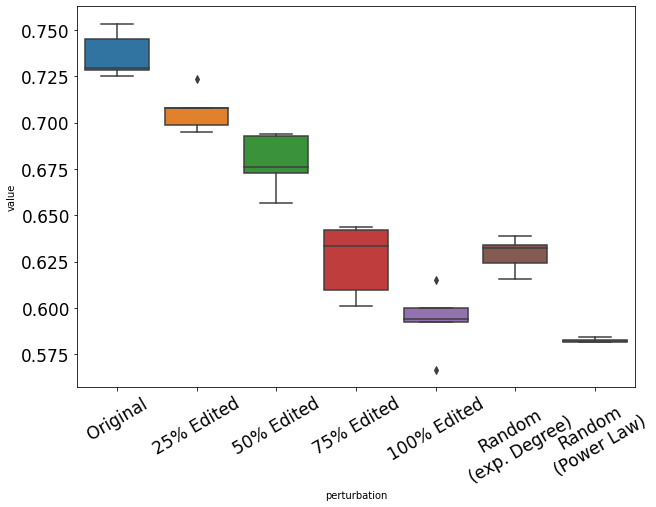

In [5]:
metrics = get_all_metrics(perturbation_folder, func=GCN_performance, kind='aupr', cv_auc_vals=True)
plot_curve(metrics, kind='box', figsize=(10, 7), ticksize=17, label_rotation=30,
           save_path=os.path.join(perturbation_folder, 'perturbations_violinplot.svg'))

## All Perturbations Simultaneously

In [6]:
metrics_features = get_all_metrics('../data/GCN/training/2020_09_28_12_04_47/', func=GCN_performance, kind='aupr', cv_auc_vals=True)
metrics_network = get_all_metrics('../data/GCN/training/2020_09_28_12_04_04/', func=GCN_performance, kind='aupr', cv_auc_vals=True)
metrics_netfeat = get_all_metrics('../data/GCN/training/2020_09_18_21_24_24/', func=GCN_performance, kind='aupr', cv_auc_vals=True)

0_feature_perturbation
Network: Original	AUPR: 0.736246564807503
0_25_feature_perturbation
Network: 25% Edited	AUPR: 0.7066290395872142
0_5_feature_perturbation
Network: 50% Edited	AUPR: 0.6785332761545682
0_75_feature_perturbation
Network: 75% Edited	AUPR: 0.6260652738599449
1_feature_perturbation
Network: 100% Edited	AUPR: 0.5937155314027636
Random_degreepreserved_feature_perturbation
Network: Random
(exp. Degree)	AUPR: 0.6290352626059604
Random_powerlaw_feature_perturbation
Network: Random
(Power Law)	AUPR: 0.5825370734694107
0_perturbation
Network: Original	AUPR: 0.7347965248459319
0_25_perturbation
Network: 25% Edited	AUPR: 0.7091383891167864
0_5_perturbation
Network: 50% Edited	AUPR: 0.6629013949679861
0_75_perturbation
Network: 75% Edited	AUPR: 0.6485729375896362
1_perturbation
Network: 100% Edited	AUPR: 0.6136866678828998
Random_degreepreserved_perturbation
Network: Random
(exp. Degree)	AUPR: 0.6433042000302585
Random_powerlaw_perturbation
Network: Random
(Power Law)	AUPR: 0.51

findfont: Font family ['Helvetica'] not found. Falling back to DejaVu Sans.


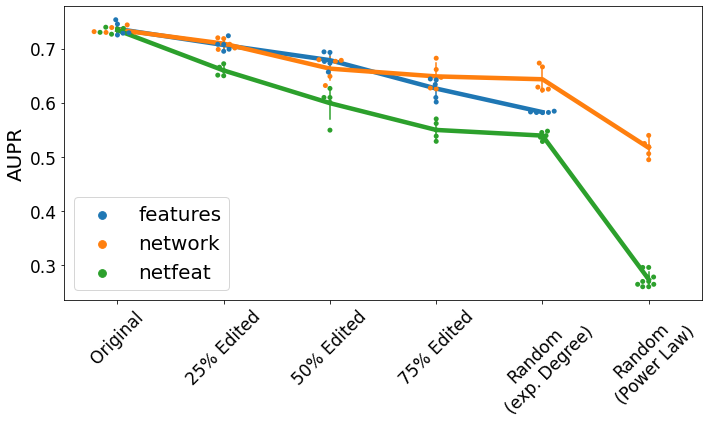

In [7]:
def make_df_from_metrics(metrics, perturbation_name='features'):
    df = pd.DataFrame([i[0] for i in metrics],
                      index=[i[1] for i in metrics],
                      columns=['CV_{}'.format(i) for i in range(len(metrics[0][0]))]
                     )
    df['perturbation'] = [_get_printable_name(i) for i in df.index]
    df['perturbation_name'] = perturbation_name
    return df


# get the feature results
df_feat = make_df_from_metrics(metrics_features, perturbation_name='features')
df_feat = df_feat.iloc[pd.Index(df_feat.index).get_indexer(['0_feature_perturbation', '0_25_feature_perturbation', '0_5_feature_perturbation',
                       '0_75_feature_perturbation', '1_feature_perturbation', 'Random_powerlaw_feature_perturbation'])]
# remove one of the random feature vectors (confusing in the final plot)
df_feat.loc[df_feat.perturbation == 'Random\n(Power Law)', 'perturbation'] = 'Random\n(exp. Degree)'

# change order for line plot
#df_feat = df_feat.loc[['0_feature_perturbation', '0_25_feature_perturbation', '0_5_feature_perturbation',
#                       '0_75_feature_perturbation', 'Random_degreepreserved_feature_perturbation'], :]
                       #'Random_powerlaw_feature_perturbation'], :]
df_net = make_df_from_metrics(metrics_network, perturbation_name='network')
df_net = df_net.iloc[pd.Index(df_net.index).get_indexer(['0_perturbation', '0_25_perturbation',
                                                              '0_5_perturbation', '0_75_perturbation', '1_perturbation',
                                                              'Random_degreepreserved_perturbation',
                                                              'Random_powerlaw_perturbation'])]
df_netfeat = make_df_from_metrics(metrics_netfeat, perturbation_name='netfeat')
df_netfeat = df_netfeat.iloc[pd.Index(df_netfeat.index).get_indexer(['0_networkfeature_perturbation', '0_25_networkfeature_perturbation',
                                                              '0_5_networkfeature_perturbation', '0_75_networkfeature_perturbation',
                                                                     '1_networkfeature_perturbation',
                                                              'Random_degreepreserved_networkfeature_perturbation',
                                                              'Random_powerlaw_networkfeature_perturbation'])]
all_metrics = pd.concat((df_feat, df_net, df_netfeat))

# plot
long = all_metrics.melt(id_vars=['perturbation', 'perturbation_name'])
long['perturbation'] = pd.Categorical(long['perturbation'], ['Original', '25% Edited', '50% Edited', '75% Edited', 
                                      'Random\n(exp. Degree)', 'Random\n(Power Law)'], ordered=True)
fig = plt.figure(figsize=(10, 6))
sns.lineplot(data=long, x='perturbation', y='value', hue='perturbation_name',
             sort=True, err_style='bars', ci='sd', legend=False, lw=4.5)
sns.swarmplot(data=long, x='perturbation', y='value', hue='perturbation_name')#, color='white', edgecolor='darkgray')#, hue='variable')
plt.tick_params(axis='both', labelsize=17)
plt.tick_params(axis='x', labelrotation=45)
plt.xlabel(None)
plt.ylabel('AUPR', fontsize=20)
plt.legend(loc='lower left', fontsize=20)
fig.tight_layout()
#fig.savefig('../data/simulation/perturbation_lineplot_rev1.svg')

In [36]:
import scipy
all_metrics = all_metrics[all_metrics.perturbation != '100% Edited']
for kind in all_metrics.perturbation_name.unique():
    perf_for_kind = all_metrics[all_metrics.perturbation_name == kind]
    previous_p = None
    for p in ['Original', '25% Edited', '50% Edited', '75% Edited', 'Random\n(exp. Degree)', 'Random\n(Power Law)']:
        if previous_p is None:
            previous_p = perf_for_kind[perf_for_kind.perturbation == p].drop(['perturbation_name', 'perturbation'], axis=1)
        else:
            next_p = perf_for_kind[perf_for_kind.perturbation == p].drop(['perturbation_name', 'perturbation'], axis=1)
            _, pval = scipy.stats.ttest_ind(previous_p.values.reshape(-1), next_p.values.reshape(-1))
            print ('[{0}] {1}: {2}'.format(kind, p, pval))
            previous_p = next_p

[features] 25% Edited: 0.003935031148203252
[features] 50% Edited: 0.010801868394306652
[features] 75% Edited: 0.0015137890082063893
[features] Random
(exp. Degree): 0.0010727013700047824
[features] Random
(Power Law): nan
[network] 25% Edited: 0.0011141645778132276
[network] 50% Edited: 0.0024194433464954247
[network] 75% Edited: 0.3495079242201364
[network] Random
(exp. Degree): 0.7383946702045361
[network] Random
(Power Law): 1.2329412928400123e-05
[netfeat] 25% Edited: 3.4525523487396635e-07
[netfeat] 50% Edited: 0.002363823425133334
[netfeat] 75% Edited: 0.011335394502527223
[netfeat] Random
(exp. Degree): 0.24102584623733647
[netfeat] Random
(Power Law): 3.714202654434638e-15


,CV_0,CV_1,CV_2,CV_3,CV_4,perturbation,perturbation_name
0_feature_perturbation,0.753,0.729,0.728,0.745,0.725,Original,features
0_25_feature_perturbation,0.708,0.724,0.699,0.695,0.708,25% Edited,features
0_5_feature_perturbation,0.657,0.676,0.693,0.694,0.673,50% Edited,features
0_75_feature_perturbation,0.644,0.610,0.634,0.642,0.601,75% Edited,features
Random_powerlaw_feature_perturbation,0.582,0.582,0.584,0.582,0.583,Random\n(exp. Degree),features
0_perturbation,0.739,0.744,0.730,0.730,0.731,Original,network
0_25_perturbation,0.718,0.701,0.720,0.698,0.708,25% Edited,network
0_5_perturbation,0.632,0.678,0.676,0.679,0.649,50% Edited,network
0_75_perturbation,0.627,0.682,0.661,0.625,0.647,75% Edited,network
1_perturbation,0.600,0.638,0.611,0.563,0.656,100% Edited,network


0_perturbation
Network: Original	AUPR: 0.7436379230722946
0_25_perturbation
Network: 25% Edited	AUPR: 0.7272207583512722
0_5_perturbation
Network: 50% Edited	AUPR: 0.7339033257380069
0_75_perturbation
Network: 75% Edited	AUPR: 0.6491759965207466
Random_degreepreserved_perturbation
Network: Random
(exp. Degree)	AUPR: 0.6798105380915422
Random_powerlaw_perturbation
Network: Random
(Power Law)	AUPR: 0.5176300562126983


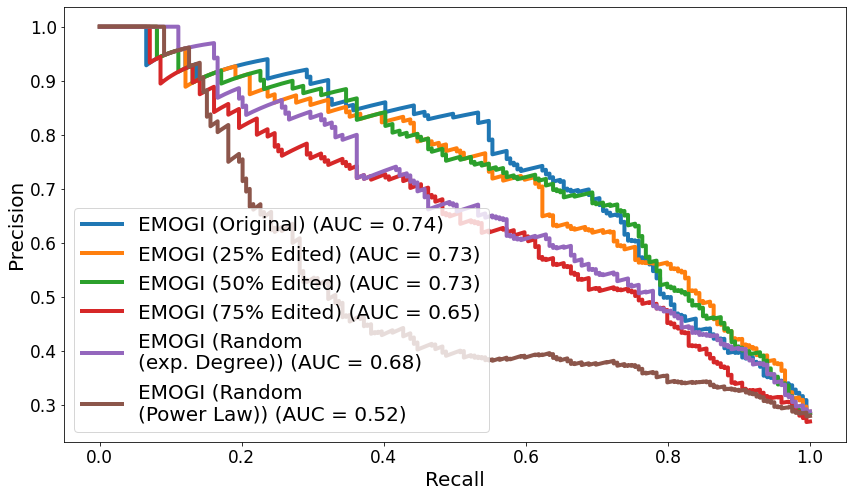

In [17]:
perturbation_folder = '../data/GCN/training/2020_09_18_21_24_24/' # features CPDB new
plot_curve(get_all_metrics(perturbation_folder, GCN_performance, 'aupr'),
           method_name='EMOGI', kind='PR', save_path=os.path.join(perturbation_folder, 'perturbations_PR.svg'))

## Random Forest Classifier on perturbed data

0_perturbation
Network: Original	AUPR: 0.5774579872662451
0_25_perturbation
Network: 25% Edited	AUPR: 0.5864601208365912
0_5_perturbation
Network: 50% Edited	AUPR: 0.5745503015548798
0_75_perturbation
Network: 75% Edited	AUPR: 0.5879270366159249
Random_degreepreserved_perturbation
Network: Random
(exp. Degree)	AUPR: 0.594230007827628
Random_powerlaw_perturbation
Network: Random
(Power Law)	AUPR: 0.5827039711938785


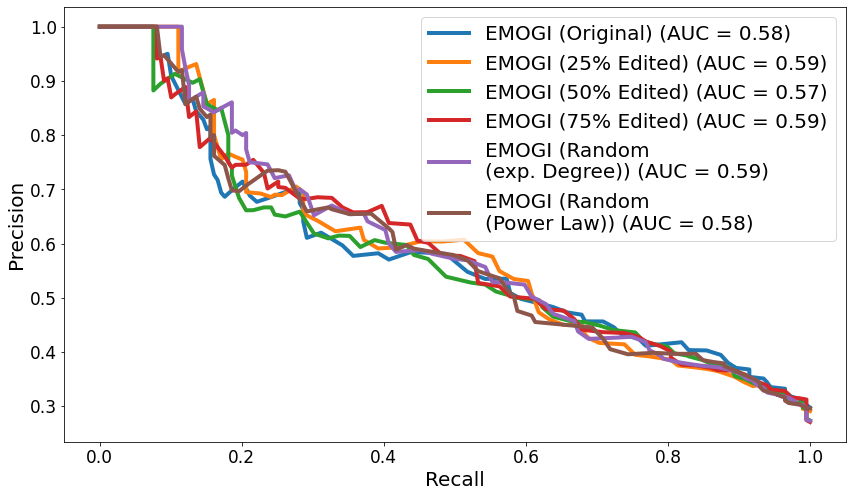

In [16]:
perturbation_folder = '../data/GCN/training/2020_09_28_12_04_47'
plot_curve(get_all_metrics(perturbation_folder, rf_performance, 'aupr'), 'EMOGI')

## PageRank algorithm on perturbed data

0_perturbation


/pkg/python-3.7.7-0/lib/python3.7/site-packages/ipykernel_launcher.py:86: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Network: Original	AUPR: 0.5937367056766978
0_25_perturbation
Network: 25% Edited	AUPR: 0.5931625426216061
0_5_perturbation
Network: 50% Edited	AUPR: 0.5948724833518781
0_75_perturbation
Network: 75% Edited	AUPR: 0.5930682466380988
Random_degreepreserved_perturbation
Network: Random
(exp. Degree)	AUPR: 0.5943035730655934
Random_powerlaw_perturbation
Network: Random
(Power Law)	AUPR: 0.3027494945831343


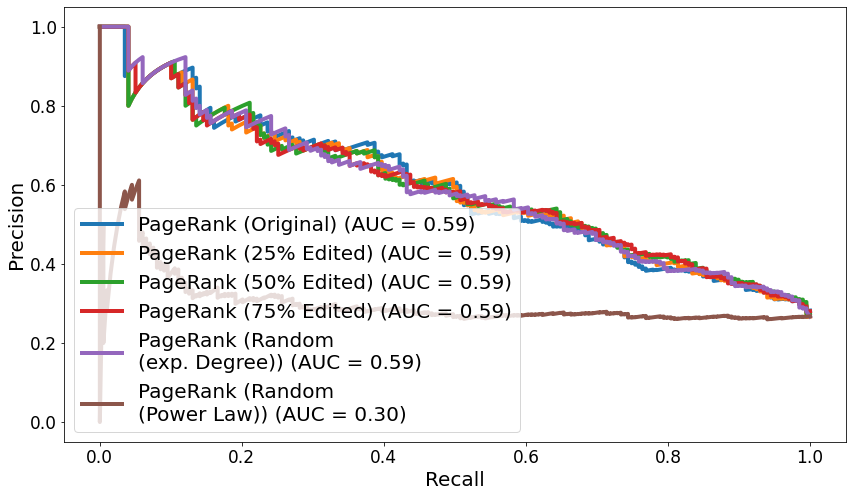

In [15]:
perturbation_folder = '../data/GCN/training/2020_09_28_12_04_47'
plot_curve(get_all_metrics(perturbation_folder, pagerank_performance), 'PageRank')